# Exploratory Data Analysis

## Importing libraries and assets

In [ ]:
# ref: https://github.com/Rak5hith-S/Visual_Question_Answering/blob/main/notebooks/1.%20Intro%20and%20EDA.ipynb

# import libraries
import json
import re
import os
import nltk
import contractions

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from nltk.tokenize import word_tokenize
from prettytable import PrettyTable
from wordcloud import WordCloud, STOPWORDS

In [ ]:
nltk.data.path.append('./nltk_data')
nltk.download('punkt', download_dir='./nltk_data')
nltk.download('punkt_tab', download_dir='./nltk_data')

[nltk_data] Downloading package punkt to ./nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to ./nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [24]:
# import data
img_dir = "Datasets/VQAv2/InputImages/training-images/train2014"
answers = json.load(open('Datasets/VQAv2/Annotations/TrainingAnnotations/v2_Annotations_Train_mscoco/v2_mscoco_train2014_annotations.json', 'r'))
questions = json.load(open('Datasets/VQAv2/InputQuestions/TrainingQuestions/v2_Questions_Train_mscoco/v2_OpenEnded_mscoco_train2014_questions.json', 'r'))

## Dataset

In [25]:
# data overview

print("Total number of images: ", len(os.listdir(img_dir)))
print("Total number of questions: ", len(questions['questions']))
print("Total number of answer annotations: ", len(answers['annotations']))
print("Total number of answers(not unique) given for a question: ",
      len(answers['annotations'][0]['answers']))

Total number of images:  82783
Total number of questions:  443757
Total number of answer annotations:  443757
Total number of answers(not unique) given for a question:  10


### Observations

- The most frequently given answer among the ten answers to a question is selected as the correct answer.

In [26]:
# convert JSON annotations of questions and answers to DataFrames and merge them based on 'image_id' and 'question_id'
questions_df = pd.DataFrame.from_records(questions['questions'])
answers_df = pd.DataFrame.from_records(answers['annotations'])
data_df = pd.merge(questions_df, answers_df, how='left', on=['image_id', 'question_id'])

# extract the list of 10 answers using list comprehension
data_df['answers'] = [[ans['answer'] for ans in ans_list] for ans_list in data_df['answers']]

# construct image paths based on 'image_id' using vectorized string operations
data_df['image_path'] = "COCO_" + answers['data_subtype'] + "_" + data_df['image_id'].astype(str).str.zfill(12) + ".jpg"
data_df['image_path'] = os.path.join(img_dir, '') + data_df['image_path']

# reorder columns
data_df = data_df[['image_path'] + list(data_df.columns[:-1])]

# drop unwanted columns
data_df.drop(['image_id', 'question_id'], axis=1, inplace=True)


In [27]:
data_df.head()

,image_path,question,question_type,multiple_choice_answer,answers,answer_type
0,Datasets/VQAv2/InputImages/training-images/tra...,What is this photo taken looking through?,what is this,net,"[net, net, net, netting, net, net, mesh, net, ...",other
1,Datasets/VQAv2/InputImages/training-images/tra...,What position is this man playing?,what,pitcher,"[pitcher, catcher, pitcher, pitcher, pitcher, ...",other
2,Datasets/VQAv2/InputImages/training-images/tra...,What color is the players shirt?,what color is the,orange,"[orange, orange, orange, orange, orange, orang...",other
3,Datasets/VQAv2/InputImages/training-images/tra...,Is this man a professional baseball player?,is this,yes,"[yes, yes, yes, yes, yes, no, yes, yes, yes, yes]",yes/no
4,Datasets/VQAv2/InputImages/training-images/tra...,What color is the snow?,what color is the,white,"[white, white, white, white, white, white, whi...",other


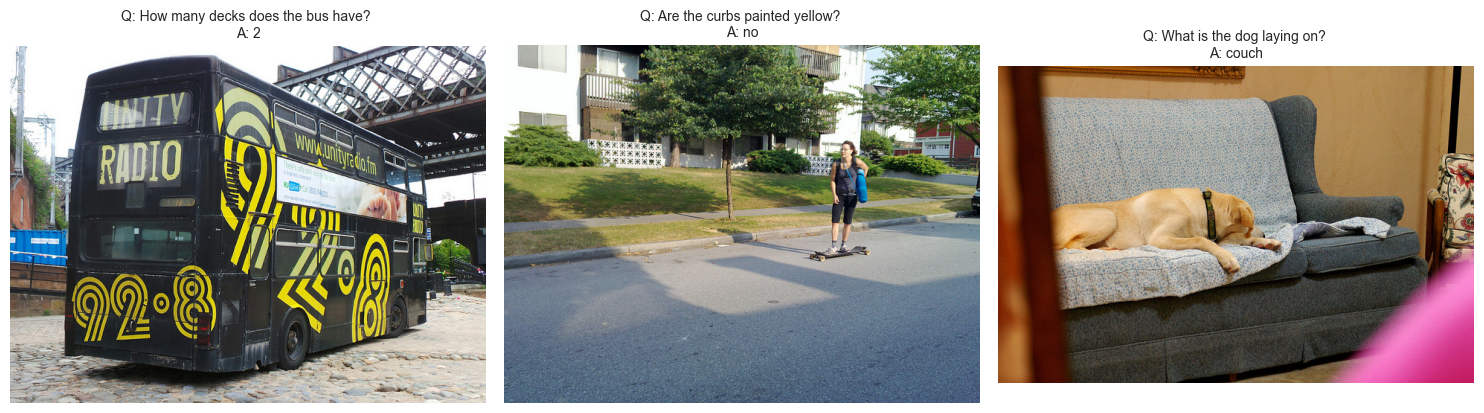

In [28]:
# no. of samples to show
n_samples = 3

# randomly sample rows from the DataFrame
sampled_df = data_df.sample(n=n_samples, replace=True)

# create subplots to display all images together
fig, axes = plt.subplots(1, n_samples, figsize=(15, 5))

# loop over sampled rows and plot images with questions and answers
for ax, (_, row) in zip(axes, sampled_df.iterrows()):
    image = mpimg.imread(row['image_path'])
    ax.imshow(image)
    ax.set_title(f"Q: {row['question']} \nA: {row['multiple_choice_answer']}", fontsize=10)
    ax.axis('off')

# adjust layout
plt.tight_layout()
plt.show()

### Observations

- The questions are open-ended, with answers that consist of numbers (for counts), yes/no (binary) responses, and words/phrases/sentences.
- The images and questions are not restricted to a specific domain.
- The widths and heights of the images vary, necessitating a standardization of their shapes during preprocessing.

## Answers

In [29]:
# calculate the count of words for every answer using word_tokenize
ans_word_count = data_df['multiple_choice_answer'].apply(lambda x: len(word_tokenize(x)))

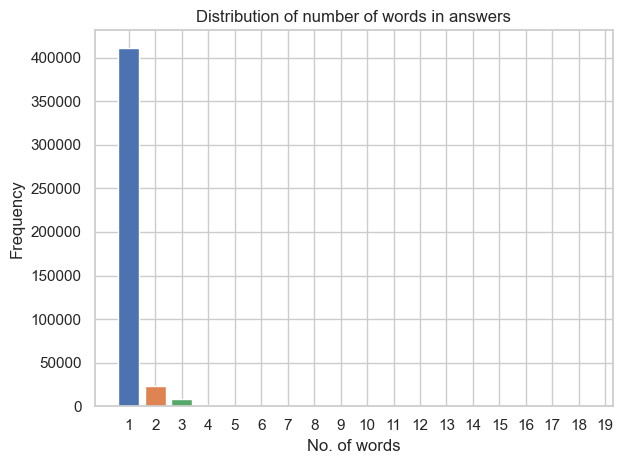

In [30]:
# define bins and their counts
counts, bins = np.histogram(ans_word_count, bins=range(1, 20))

# use a colormap for different colors
colors = sns.color_palette("deep", n_colors=len(counts))

# plot the distribution of word counts with gaps
plt.bar(bins[:-1], counts, width=0.8, color=colors)

# plot settings
plt.title("Distribution of number of words in answers")
plt.xlabel("No. of words")
plt.ylabel("Frequency")
plt.grid(True)
plt.xticks(bins)
plt.tight_layout()
plt.show()


### Observations

- Majority of the answers consist of 1 to 3 words.

*Limiting the problem to 1 word answers.*

In [31]:
# choosing samples with only 1 word answers
data_df = data_df[ans_word_count == 1]
data_df.shape

(410857, 6)

*EDA below is now limited to only samples with 1-word answers*

In [32]:
# types of answers
print("Different answer types:", data_df['answer_type'].unique())

Different answer types: ['other' 'yes/no' 'number']


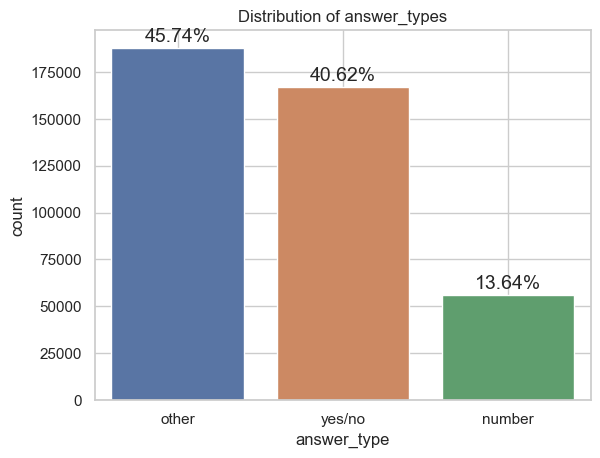

In [33]:
# plot the count of different answer types
ax = sns.countplot(data=data_df, x='answer_type', hue='answer_type', palette='deep', legend=False)

# annotating bars with percentages
total = len(data_df)
for p in ax.patches:
    percentage = '{:.2f}%'.format(100 * p.get_height() / total)
    ax.annotate(percentage, (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', size=14, xytext=(0, 8),
                textcoords='offset points')

# set plot title and grid
plt.title("Distribution of answer_types")
plt.grid(True)
plt.show()

### Observations

- 40.62% of all answers pertain to questions that anticipate a binary yes/no response.
- 13.64% are numerical answers, while the remaining 45.74% consist of various other one-word answers.

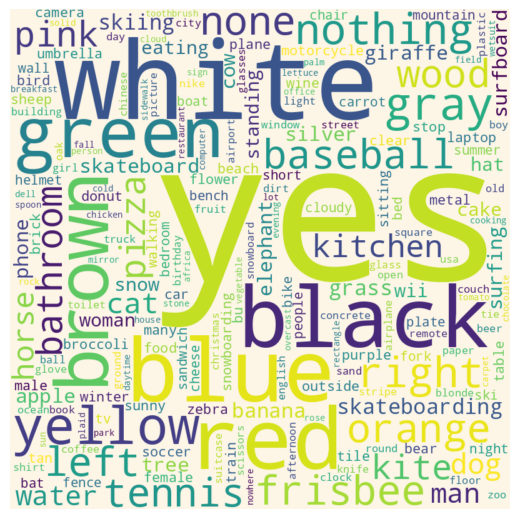

In [34]:
# generate the word cloud
text = " ".join(data_df['multiple_choice_answer'])
wc = WordCloud(width=800, height=800, background_color='oldlace',
               collocations=False, min_font_size=10).generate(text)

# plot the WordCloud image
with plt.style.context('ggplot'):
    plt.figure(figsize=(8, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

### Observations

- The answer "yes" is the most commonly encountered response, aligning with questions that seek a binary yes/no answer.
- Colors are also frequently mentioned, suggesting that many questions inquire about the color of various elements in an image.

In [35]:
# computing frequency of one-word answers
one_word_ans_freq = data_df['multiple_choice_answer'].value_counts()

print("Total number of unique one-word answers: ",
      one_word_ans_freq.keys().nunique())

Total number of unique one-word answers:  10223


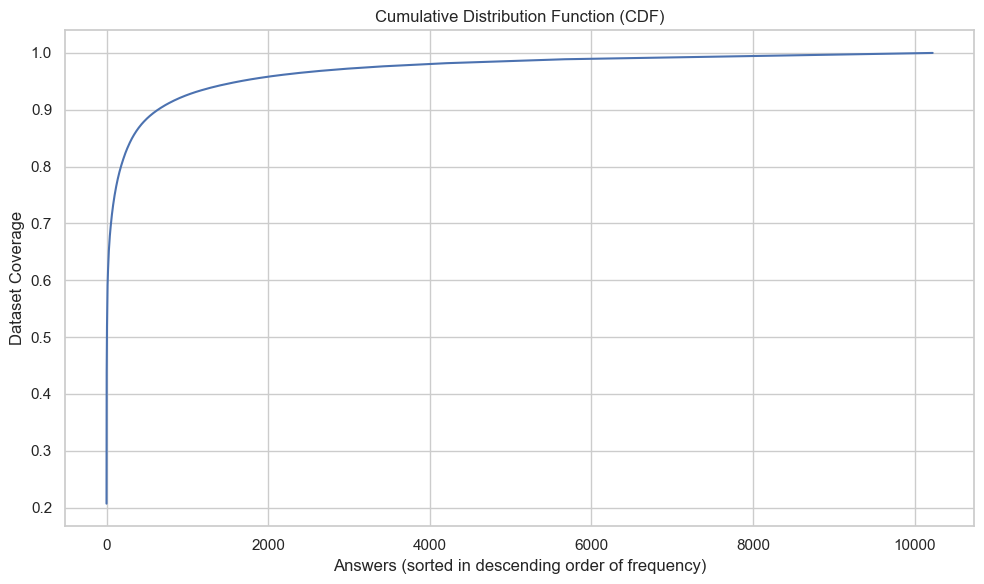

+----------+--------------+------------------+
| Answers  | Answer count | Dataset Coverage |
+----------+--------------+------------------+
| Top_100  |     349      |      74.95       |
| Top_300  |     120      |      84.56       |
| Top_500  |      56      |      88.45       |
| Top_700  |      35      |      90.59       |
| Top_900  |      25      |      92.05       |
| Top_1000 |      22      |      92.62       |
| Top_1300 |      15      |      93.93       |
| Top_1500 |      12      |      94.59       |
+----------+--------------+------------------+


C:\Users\User\AppData\Local\Temp\ipykernel_18372\3769112881.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coverage = np.round(ans_cum_sum[i] * 100, 2)


In [36]:
# calculate cumulative distribution of answers
ans_frac = one_word_ans_freq / one_word_ans_freq.sum()
ans_cum_sum = np.cumsum(ans_frac)

# plotting the cumulative distribution function (CDF)
sns.set(style='whitegrid')  # Set seaborn style for better aesthetics
plt.figure(figsize=(10, 6))
sns.lineplot(x=np.arange(len(ans_cum_sum)), y=ans_cum_sum)
plt.grid(True)
plt.xlabel('Answers (sorted in descending order of frequency)')
plt.ylabel('Dataset Coverage')
plt.title("Cumulative Distribution Function (CDF)")
plt.tight_layout()
plt.show()

# Calculating % of the dataset covered by each answer
summary = PrettyTable()
summary = PrettyTable(["Answers", "Answer count", "Dataset Coverage"])
top_x = [100, 300, 500, 700, 900, 1000, 1300, 1500]

for i in top_x:
    if i < len(one_word_ans_freq):
        answer = one_word_ans_freq.iloc[i]
        coverage = np.round(ans_cum_sum[i] * 100, 2)
        summary.add_row([f'Top_{i}', answer, coverage])

print(summary)



### Observations
- A small number of answers account for the majority of the dataset.
- The top 100 answers make up approximately 75% of the entire dataset.
- Select only the samples with answers that fall within these top 100 frequent responses will result in 𝑘 = 100, allowing to frame the task as a 100-class classification problem.

In [37]:
# choosing samples whose answers are part of the top 100 most frequent answers
top_100_answers = one_word_ans_freq.nlargest(100).index  # Get the top 100 most frequent answers
data_df = data_df[data_df['multiple_choice_answer'].isin(top_100_answers)]

# display the new shape of the DataFrame
print(f"Filtered DataFrame shape: {len(data_df)}")

data_df.shape

Filtered DataFrame shape: 307568


(307568, 6)

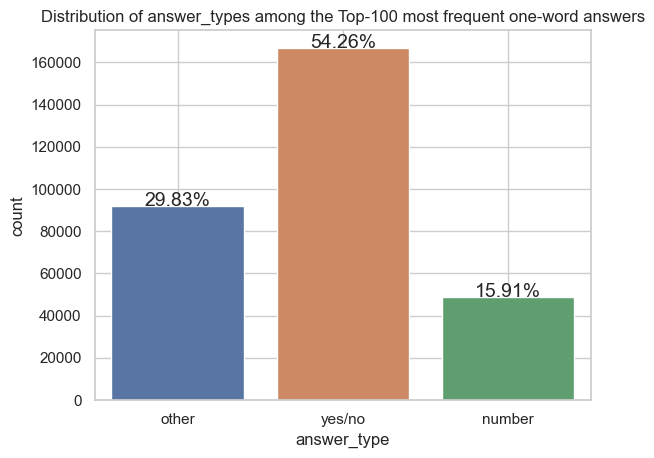

In [38]:
# Create a count plot
ax = sns.countplot(data=data_df, x='answer_type', hue='answer_type', palette='deep', legend=False)

# Annotating
for p in ax.patches:
    ax.annotate(
        '{:.2f}%'.format(
        (p.get_height()/len(data_df))*100),
        (p.get_x()+0.2, p.get_height()),
        size=14
    )

plt.title("Distribution of answer_types among the Top-100 most frequent one-word answers")
plt.grid(True)
plt.show()

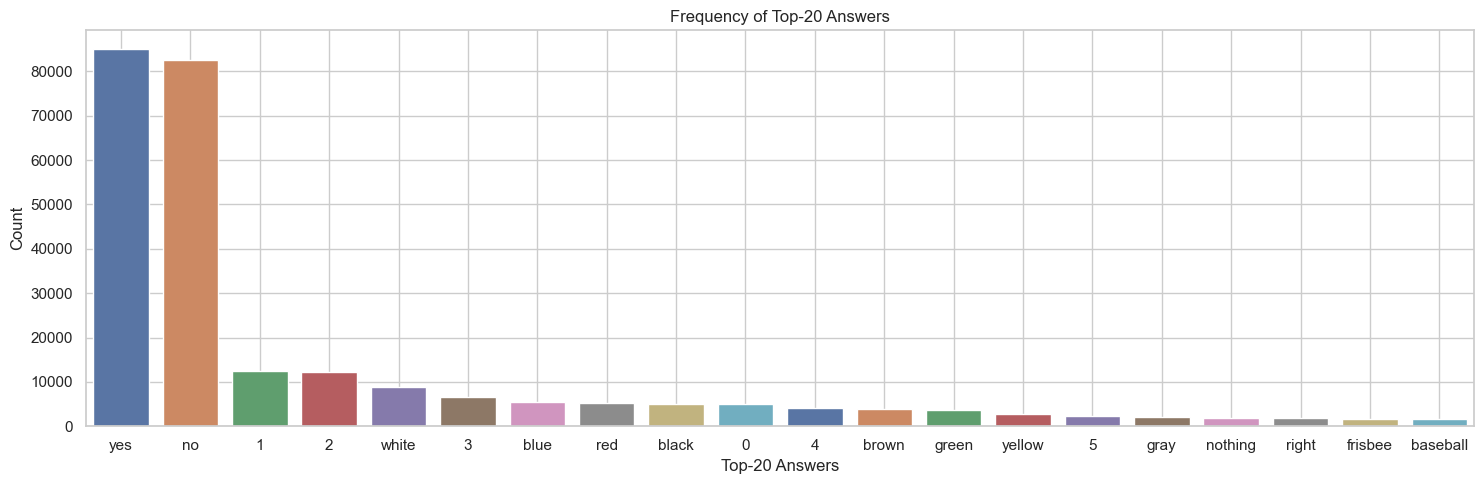

In [39]:
# frequency of Top-20 answers
top_k = 20

# get the top 20 most frequent answers
top_answers = one_word_ans_freq.nlargest(top_k)

plt.figure(figsize=(15, 5))
sns.barplot(x=top_answers.index, y=top_answers.values, hue=top_answers.index, palette='deep', legend=False)
plt.title(f"Frequency of Top-{top_k} Answers")
plt.xlabel("Top-20 Answers")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()

### Observations

- A significant portion of the dataset, specifically 54.26%, consists of samples with binary answers (yes/no).
- In addition to 'yes' and 'no', numbers and colors also rank among the most frequently given responses.

This suggests that many questions pertain to counting elements or identifying colors within an image.


## Questions

The annotations released has the following cleaning steps already done on the raw crowdsourced data:

- Spelling correction (using Bing Speller) of question and answer strings
- Question normalization (first char uppercase, last char ‘?’)
- Answer normalization (all chars lowercase, no period except as decimal point, number words —> digits, strip articles (a, an the))
- Adding apostrophe if a contraction is missing it (e.g., convert "dont" to "don't")

Source: [link](https://visualqa.org/download.html#:~:text=from%20here.-,Overview,-The%20annotations%20we)

In [40]:
data_df['question'].sample(10)

123550           How many scissors are there?
96898                       Are they sisters?
216053                        How many for 1?
277765       How many slats are in the fence?
51697     Is there a bottle behind the pizza?
433891                What is this kid doing?
343010                 What color is the sky?
276702             What is this shoe made of?
379941          What color are the elephants?
124809       How many orange cones are there?
Name: question, dtype: object

In [41]:
# removing contractions

print("="*50)
print("you're happy now =>", contractions.fix("you're happy now"))
print("="*50)
print("Ram's dog =>", contractions.fix("Ram's dog"))
print("="*50)
print("I'll be there =>", contractions.fix("I'll be there"))

you're happy now => you are happy now
Ram's dog => Ram's dog
I'll be there => I will be there


In [42]:
def preprocess_questions(text):
    """
    Normalize the questions by correcting contractions, converting the text to lowercase, and eliminating any special characters.
    """
    text = contractions.fix(text)
    text = text.lower()
    text = re.sub('[^A-Za-z0-9]+', ' ', text)
    return text

In [43]:
data_df['question'] = data_df['question'].apply(lambda x: preprocess_questions(x))

data_df['question'].sample(10)

168682                             is this in a large city 
65688            what is sitting on top of a cutting board 
143085                             what is the girl eating 
277568                        can one still drive this car 
122258                                     are there tents 
107295                 do you see a leopard style suitcase 
349082                             is this train in motion 
410343                           what color is her sweater 
341445    does it appear salt or pepper has been used on...
16529                         how many manual toothbrushes 
Name: question, dtype: object

In [44]:
# calculating the count of words for every question
question_word_count = data_df['question'].apply(
    lambda x: len(word_tokenize(x)))

In [ ]:
print("Min no. of words: ", min(question_word_count))
print("Max no. of words: ", max(question_word_count))

x = PrettyTable()
x.field_names = ["Percentile", "No. of words"]

for i in range(95, 101, 1):
    x.add_row([i, np.round(np.percentile(question_word_count, i), 3)])
print(x)

Min no. of words:  2
Max no. of words:  22
+------------+--------------+
| Percentile | No. of words |
+------------+--------------+
|     95     |     9.0      |
|     96     |     10.0     |
|     97     |     10.0     |
|     98     |     11.0     |
|     99     |     12.0     |
|    100     |     22.0     |
+------------+--------------+


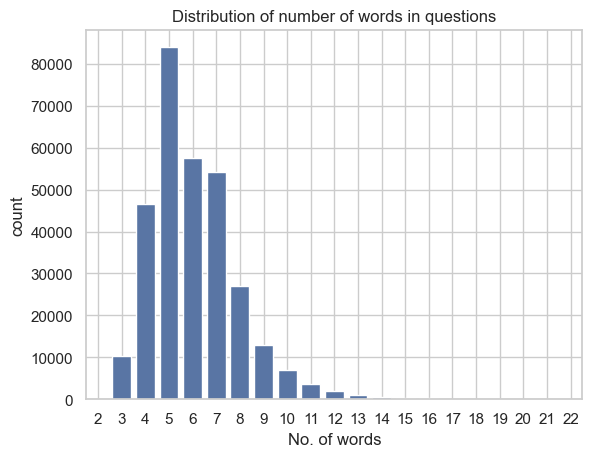

In [45]:
sns.countplot(x=question_word_count)
plt.title("Distribution of number of words in questions")
plt.xlabel("No. of words")
plt.grid(True)
plt.show()

### Observations

- The majority of questions are short and consist of only a few words.

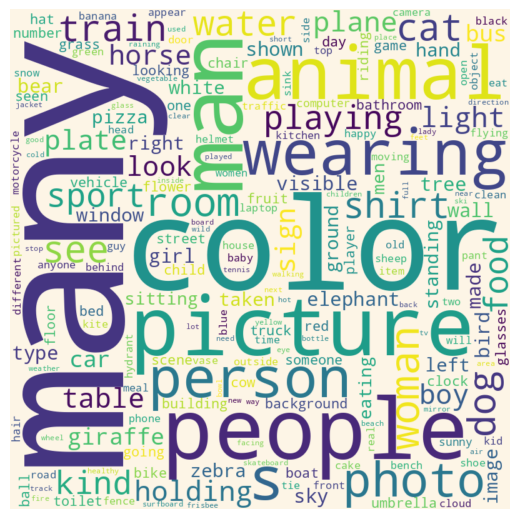

In [46]:
# generate the word cloud
text = " ".join(data_df['question'])
wc = WordCloud(width=800, height=800, background_color='oldlace',
               collocations=False, min_font_size=10).generate(text)

# plot the WordCloud image
with plt.style.context('ggplot'):
    plt.figure(figsize=(8, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

### Observations

- As noted earlier, the frequent occurrence of the words 'color' and 'many' suggests that many questions inquire about the color and count of various elements in an image. This pattern was also evident during the analysis of the answers.

In [47]:
print("Total number of unique question_type: ", data_df['question_type'].nunique())

Total number of unique question_type:  65


In [48]:
data_df['question_type'].unique()

array(['what color is the', 'is this', 'what is the person',
       'what is in the', 'is the', 'is there', 'is', 'is the man',
       'none of the above', 'does the', 'are the', 'was', 'what is this',
       'how many', 'what color is', 'what is the man', 'what is on the',
       'how many people are in', 'is there a', 'is it', 'is the person',
       'what is the', 'is this a', 'what', 'are there', 'has', 'could',
       'are', 'are they', 'are these', 'how many people are',
       'what color are the', 'where are the', 'which', 'do',
       'what is the color of the', 'what color', 'what sport is',
       'what are the', 'does this', 'is the woman', 'where is the',
       'are there any', 'is that a', 'what kind of', 'what is',
       'what type of', 'is this an', 'do you', 'what are',
       'is this person', 'can you', 'is he', 'how', 'what brand',
       'what is the name', 'who is', 'why is the', 'what animal is',
       'what does the', 'what number is', 'what room is',
       

In [49]:
# calculating frequency of question_types
question_type_freq = data_df['question_type'].value_counts()

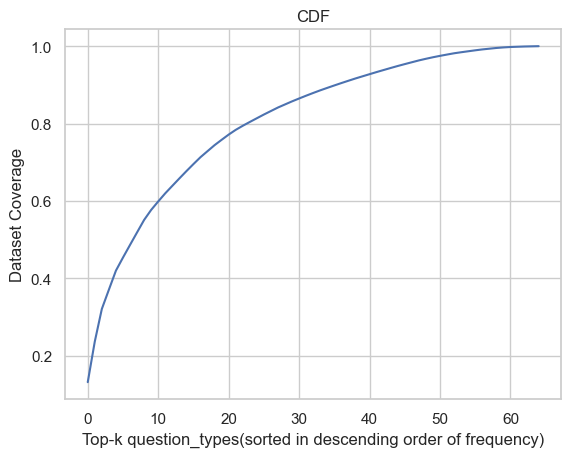

In [50]:

# calculating cumulative distribution of question_types
ques_frac = question_type_freq / np.sum(question_type_freq)
ques_cum_sum = np.cumsum(ques_frac)

# plotting
sns.lineplot(x=np.arange(len(ques_cum_sum)), y=ques_cum_sum)
plt.xlabel('Top-k question_types(sorted in descending order of frequency)')
plt.ylabel('Dataset Coverage')
plt.title("CDF")
plt.grid(True)
plt.show()

### Observations

- The distribution of question types is fairly balanced, meaning that most of the dataset is not concentrated in just a few question types.

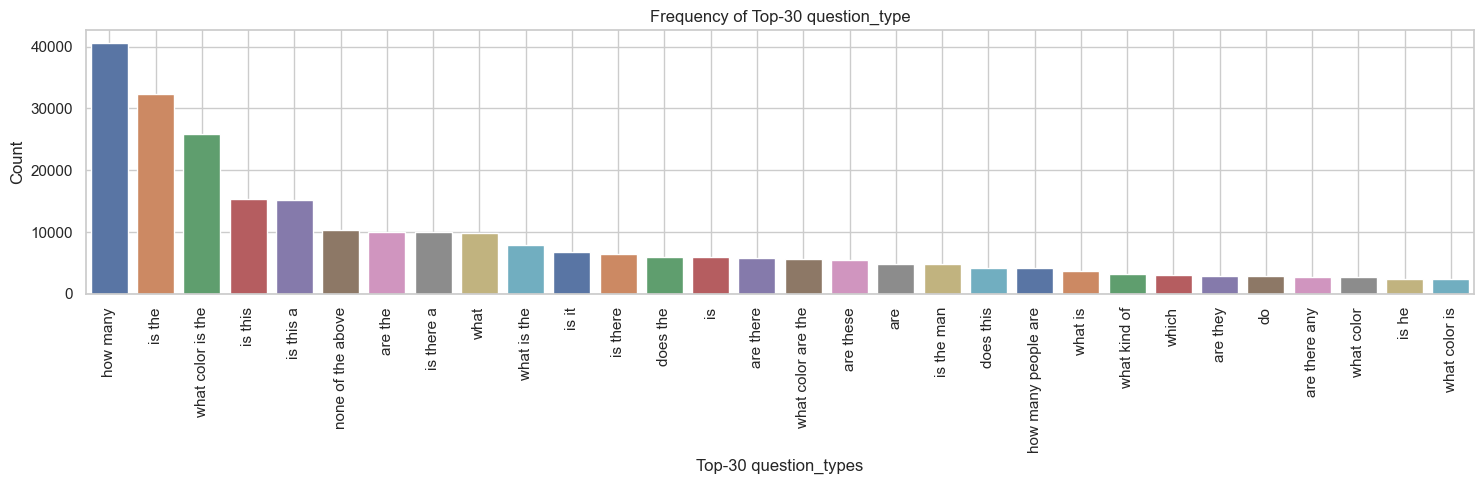

In [51]:
top_k=30

plt.figure(figsize=(15, 5))
sns.barplot(
    x=question_type_freq[:top_k].keys(), y=question_type_freq[:top_k].values,
    hue=question_type_freq[:top_k].keys(), palette='deep', legend=False)
plt.title(f"Frequency of Top-{top_k} question_type")
plt.xticks(rotation=90)
plt.xlabel("Top-30 question_types")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()

### Observations

- The question types mentioned above proves the earlier findings that many questions inquire about color and count.

In [52]:
top_k = 30

# get top-k question types
top_k_ques_types = question_type_freq.nlargest(top_k).index

# create a cross-tabulation of question types vs answer types
ques_vs_ans_type_df = pd.crosstab(
    data_df[data_df['question_type'].isin(top_k_ques_types)]['question_type'],
    data_df['answer_type'],
    dropna=False
)

# optionally reindex to ensure the DataFrame has all top_k_ques_types as index
ques_vs_ans_type_df = ques_vs_ans_type_df.reindex(top_k_ques_types, fill_value=0)

In [53]:
# display the result
ques_vs_ans_type_df.head()

answer_type,number,other,yes/no
question_type,,,
how many,40496,111,0
is the,11,701,31584
what color is the,0,25883,0
is this,7,147,15148
is this a,6,340,14798


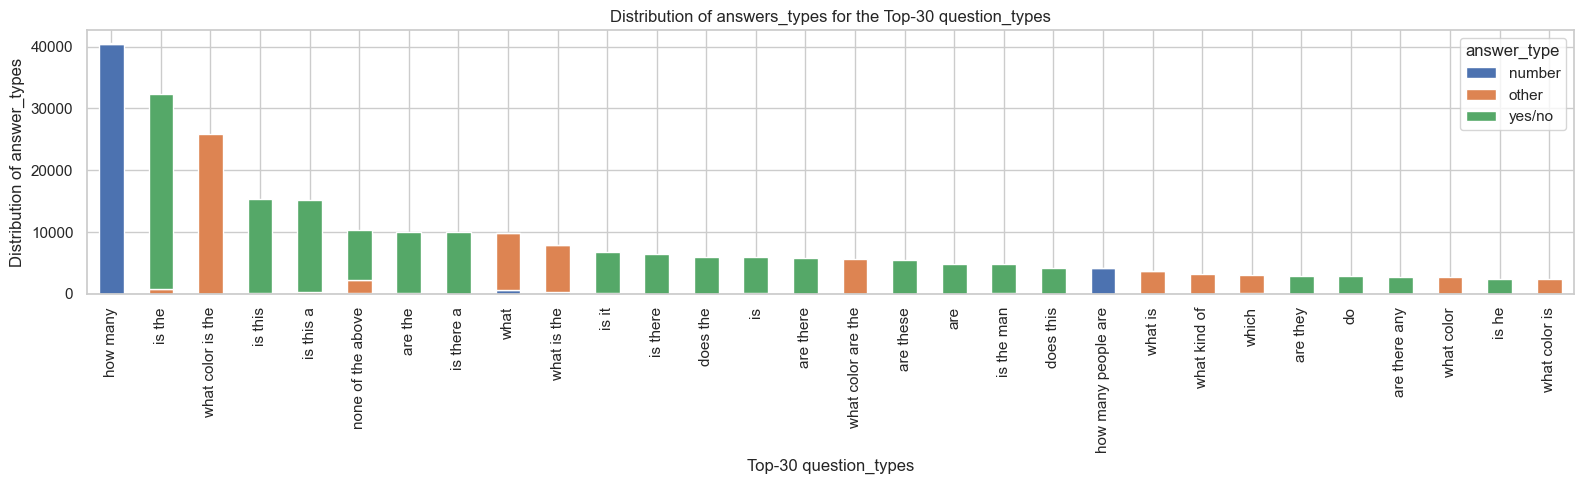

In [54]:
ques_vs_ans_type_df.plot.bar(rot=90, stacked=True, figsize=(16, 5))

plt.xlabel("Top-30 question_types")
plt.ylabel("Distribution of answer_types")
plt.title("Distribution of answers_types for the Top-30 question_types")
plt.grid(True)
plt.tight_layout()
plt.show()

### Observations

- Most questions beginning with "is," "are," and "does" are associated with binary yes/no answers.
- Questions that start with "how" tend to focus on count-based inquiries, often yielding numerical answers.
- Questions beginning with "what" and "which" typically correspond to other one-word responses.

## Images

In [55]:
# extract image shapes
img_shapes = data_df['image_path'].map(lambda x: mpimg.imread(x).shape)

In [56]:
# print the number of unique dimensions
print("Number of unique dimensions: ", set(map(len, img_shapes)))

Number of unique dimensions:  {2, 3}


### Observations

- Some of the images lack depth or channels, which suggests that they may be grayscale images.

In [57]:
# directly compute unique heights and widths
img_heights = np.asarray([img_shape[0] for img_shape in img_shapes])
img_widths = np.asarray([img_shape[1] for img_shape in img_shapes])

# print the number of unique values in heights and widths
print("Number of unique values in heights: ", len(set(img_heights)))
print("Number of unique values in widths: ", len(set(img_widths)))


Number of unique values in heights:  503
Number of unique values in widths:  439


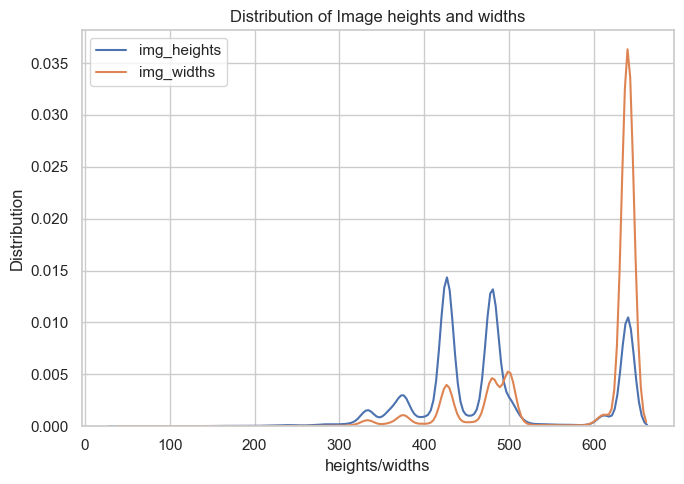

In [58]:

plt.figure(figsize=(7,5))
sns.kdeplot(img_heights, label="img_heights")
sns.kdeplot(img_widths, label="img_widths")
plt.title('Distribution of Image heights and widths')
plt.xlabel('heights/widths')
plt.ylabel('Distribution')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [59]:
print("Image widths below 100: ", img_widths[img_widths < 100])
print("Image heights below 100: ", img_heights[img_heights < 100])

Image widths below 100:  [72 72 72 59 59]
Image heights below 100:  [51 51 51 72 72]


### Observations
- It's important to note that although most images are large, there are a few with smaller widths and heights, as observed above. These smaller images may lose resolution if they are enlarged during preprocessing for model training.

## Summarized Observations from EDA

*Dataset Overview*

- The dataset consists of open-ended questions with answers that are either numbers (for counts), yes/no (binary), or words/phrases/sentences.
- The images and questions span various domains, without being confined to a particular subject.
- Each question is accompanied by 10 answers provided by different annotators, and the most common answer is selected as the correct one.

*Answers*

- Most answers are 1-3 words long. Given resource constraints, the problem is simplified to focus on 1-word answers.
- After filtering the dataset to include only 1-word answers, a small subset of answers covers most of the dataset.
- "Yes" is the most frequent answer, indicating many binary yes/no questions. This is followed by answers related to colors, suggesting a significant number of questions ask about the color of an element in the image.
- There are 10,223 unique one-word answers in total. To convert the task into a k-class classification problem, the dataset is further filtered to focus on a manageable number of answers.
- The top-100 most frequent answers cover approximately 75% of the dataset, making this a 100-class classification problem.
- After filtering, 54.26% of the dataset consists of binary yes/no answers. Apart from "yes" and "no," numbers and colors are prevalent in the top-100 most frequent answers, supporting the observation that many questions ask for counts or colors.

*Questions*

- The annotations have undergone the following data cleaning steps.
    - Spelling correction (using Bing Speller) for both questions and answers.
    - Normalization of questions: ensuring the first character is uppercase and each question ends with a question mark ('?').
    - Normalization of answers: converting all characters to lowercase, removing periods (except for decimal points), changing number words to digits, and stripping articles like "a," "an," and "the."
    - Adding apostrophes where contractions were missing (e.g., changing "dont" to "don't").
- The questions are concise and well-formatted, although some contractions like "that's" and possessives like "man's" are present, along with special symbols like "?". These elements need to be handled with care.
- A majority of the questions contain just a few words, with "color" and "many" being frequent, which aligns with the earlier observation that many questions focus on identifying the count or color of objects in images.
- The questions also follow specific patterns.
    - Questions starting with "is," "are," or "does" generally expect yes/no answers.
    - Questions starting with "how" typically relate to counting and have numerical answers.
    - Questions starting with "what" or "which" often correspond to one-word answers, such as colors.

*Images*

- The images in the dataset vary in shape and size. Some images lack color channels, which suggests they might be grayscale images.
- While most images have large dimensions, there are a few with smaller widths and heights. Enlarging these smaller images during preprocessing could result in a loss of resolution, which may affect model training.